In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df_train = pd.read_csv("train.csv")

In [21]:
df_train = df_train.reindex(columns=['user_id', 'date', 'id1', 'id2', 'id3'])

### Does the number of impressions depend on the workday?
We find that there seems to be a variation of the number of unique users with the workday. More interestingly, we also find a large decline in the number of impressions in the second half of the time period.

In [8]:
%%time
# Determining the number of impressions per day
number_of_impressions_per_day = np.zeros(54)
number_of_unique_visitors_per_day = np.zeros(54)
for d in range(1, 55):
    tmp = df_train[df_train['date'] == d]['user_id']
    number_of_impressions_per_day[d-1] = tmp.size
    number_of_unique_visitors_per_day[d-1] = tmp.unique().size

CPU times: user 3.99 s, sys: 1.15 s, total: 5.14 s
Wall time: 5.16 s


In [9]:
daily_average_users, daily_average_impressions, day_count = np.zeros(7), np.zeros(7), np.zeros(7)
for d in range(0, 54):
    daily_average_users[d % 7] += number_of_unique_visitors_per_day[d]
    daily_average_impressions[d % 7] += number_of_impressions_per_day[d]
    day_count[d % 7] += 1
    
daily_average_users = np.divide(daily_average_users, day_count)
daily_average_impressions = np.divide(daily_average_impressions, day_count)

Text(0,0.5,'Average number of impressions')

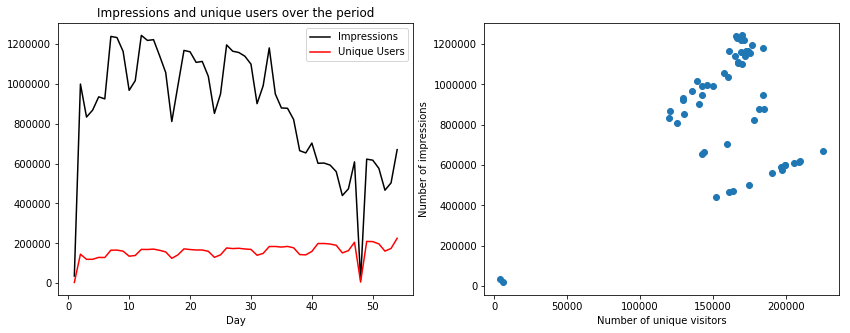

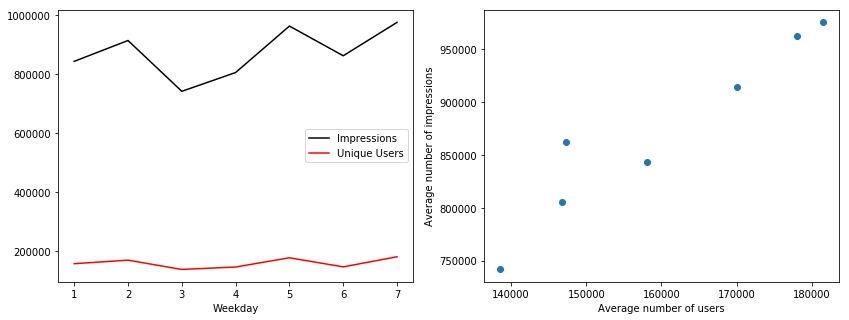

In [20]:
plt.figure(figsize=(14, 5))
# Plotting the time series
plt.subplot(1, 2, 1)
plt.plot(range(1, 55), number_of_impressions_per_day, 'k')
plt.plot(range(1, 55), number_of_unique_visitors_per_day, 'r')
plt.legend(['Impressions', 'Unique Users'])
plt.xlabel('Day')
plt.title('Impressions and unique users over the period')

# Evaluating the relationship between unique visitors per day
# and number of impressions
plt.subplot(1, 2, 2)
plt.scatter(number_of_unique_visitors_per_day, number_of_impressions_per_day)
plt.xlabel('Number of unique visitors')
plt.ylabel('Number of impressions')

## Plotting the average results
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,8), daily_average_impressions, 'k')
plt.plot(range(1,8), daily_average_users, 'r')
plt.legend(['Impressions', 'Unique Users'])
plt.xlabel('Weekday')

plt.subplot(1, 2, 2)
plt.scatter(daily_average_users, daily_average_impressions)
plt.xlabel('Average number of users')
plt.ylabel('Average number of impressions')


### How many impressions does the average user have? What is the distribution of the impressions per user?

In [22]:
grouped_user = df_train.groupby('user_id').count()
grouped_user['count'] = grouped_user['date']
grouped_user.drop(['date', 'id1', 'id2', 'id3'], inplace=True, axis=1)
grouped_user['log_count'] = np.log10(grouped_user['count'])

Some observations (details below):
- The median of the number of impressions is 9, but the median is 43.
- The distribution of the impressions seems to follow a power law.

In [24]:
grouped_user.describe()

,count,log_count
count,1.079572e+06,1.079572e+06
mean,4.353283e+01,1.006251e+00
std,1.558430e+02,6.900850e-01
min,1.000000e+00,0.000000e+00
25%,3.000000e+00,4.771213e-01
50%,9.000000e+00,9.542425e-01
75%,2.800000e+01,1.447158e+00
max,1.904100e+04,4.279690e+00


In [29]:
total_impressions = grouped_user['count'].sum(axis=0)
percentage_impressions = np.zeros(11)
ct = 0
for imps in [2 ** i for i in range(11)]:
    percentage_impressions[ct] = grouped_user[grouped_user['count'] >= imps]['count'].sum(axis=0) / total_impressions
    ct+=1

Text(0,0.5,'Fraction of visitors')

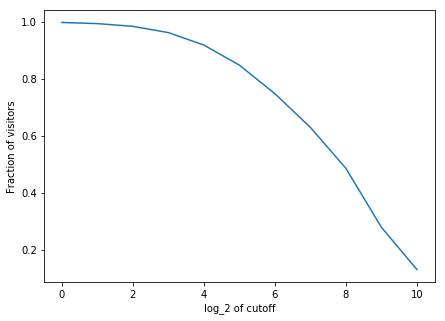

In [34]:
plt.figure(figsize=(7, 5))
plt.plot(range(11), percentage_impressions)
plt.xlabel('log_2 of cutoff')
plt.ylabel('Fraction of visitors')

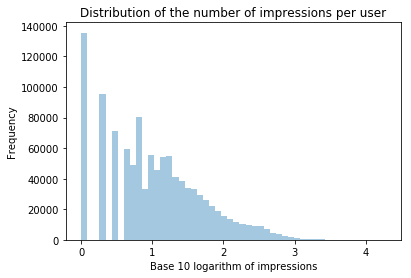

In [23]:
sns.distplot(grouped_user['log_count'], kde=False)
plt.title('Distribution of the number of impressions per user')
plt.xlabel('Base 10 logarithm of impressions')
plt.ylabel('Frequency')
plt.savefig('Logplot_Distribution_impressions.jpg')

### What is the probability that people will visit in a given day if they have visited today?


In [36]:
%%time
future_date_jaccard_metric = np.zeros((54, 54))
for d1 in range(1, 54):
    u1 = df_train[df_train['date'] == d1]['user_id'].unique()
    for d2 in range(d1, 55):
        u2 = df_train[df_train['date'] == d2]['user_id'].unique()
        
        s1 = u1.size
        s2 = u2.size
        s_cb = np.intersect1d(u1, u2).size
        
        future_date_jaccard_metric[d1-1, d2-1] = s_cb / (s1 + s2 - s_cb)

CPU times: user 5min 1s, sys: 1min 22s, total: 6min 24s
Wall time: 6min 43s


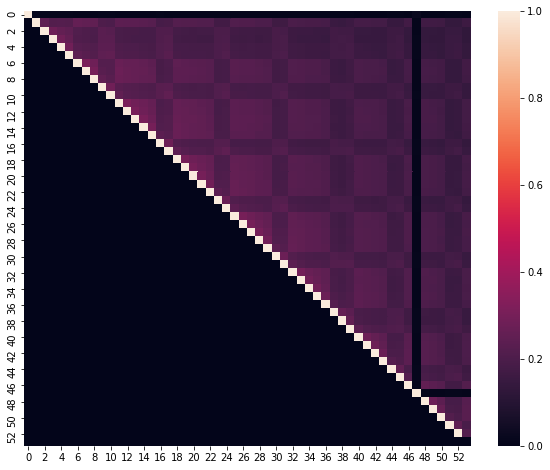

In [38]:
plt.figure(figsize=(10, 8))
sns.heatmap(future_date_jaccard_metric)

Let us look only at those users that have at least 100 impressions.

In [39]:
at_least_100_impressions_users = grouped_user[grouped_user['count'] >= 100]

In [41]:
df_100 = df_train.set_index(['user_id'])

In [43]:
df_100.sort_index(inplace=True)
at_least_100_impressions_users.sort_index(inplace=True)

In [54]:
frequent_users = df_100.join(at_least_100_impressions_users, how='inner')

In [51]:
frequent_users.shape[0]

31755029

In [47]:
at_least_100_impressions_users.size

194660

In [61]:
grouped_user[grouped_user['count'] >= 100]['count'].sum()

31755029

In [49]:
frequent_users.head()

,date,id1,id2,id3,count,log_count
user_id,,,,,,
11,18,9,12,329,423,2.62634
11,29,6,58,572,423,2.62634
11,12,8,96,136,423,2.62634
11,12,6,47,566,423,2.62634
11,16,6,3,281,423,2.62634


In [55]:
frequent_users.reset_index(inplace=True)
frequent_users.set_index(['user_id', 'date'], inplace=True)
# frequent_users.drop(['log_count'], inplace=True, axis=0)

TypeError: Expected tuple, got str

In [56]:
frequent_users.head()

id1  id2  id3  count  log_count
user_id date                                 
11      18      9   12  329    423    2.62634
        29      6   58  572    423    2.62634
        12      8   96  136    423    2.62634
        12      6   47  566    423    2.62634
        16      6    3  281    423    2.62634

In [57]:
frequent_users.drop('log_count', axis=1, inplace=True)

In [58]:
frequent_users.head()

id1  id2  id3  count
user_id date                      
11      18      9   12  329    423
        29      6   58  572    423
        12      8   96  136    423
        12      6   47  566    423
        16      6    3  281    423

In [62]:
frequent_users.sort_index(inplace=True)

In [63]:
frequent_users.head()

id1  id2  id3  count
user_id date                      
11      4       9   12  610    423
        4      10   14  581    423
        4       9   12  204    423
        4       7   40   41    423
        4       6   47  749    423

In [64]:
frequent_users.reset_index(inplace=True)

Let's do some experiment with next day product probabilities

In [72]:
%%time

one_day_transfer_matrix = np.zeros((16, 16))
d1 = 2
d2 = 3
for pn1 in range(16):
    u1 = frequent_users[(frequent_users['id1'] == pn1) & (frequent_users['date'] == d1)]['user_id'].unique()
    s1 = u1.shape[0]
    for pn2 in range(16):
        u2 = frequent_users[(frequent_users['id1'] == pn2) & (frequent_users['date'] == d2)]['user_id'].unique()
        
        s2 = u2.shape[0]
        us = np.intersect1d(u1, u2, assume_unique=True).shape[0]
        
        if s1 + s2 == 0:
            one_day_transfer_matrix[pn1, pn2] = 0.0
        else:
            one_day_transfer_matrix[pn1, pn2] = us / (s1 + s2 - us)

CPU times: user 26.6 s, sys: 12 s, total: 38.6 s
Wall time: 40.4 s


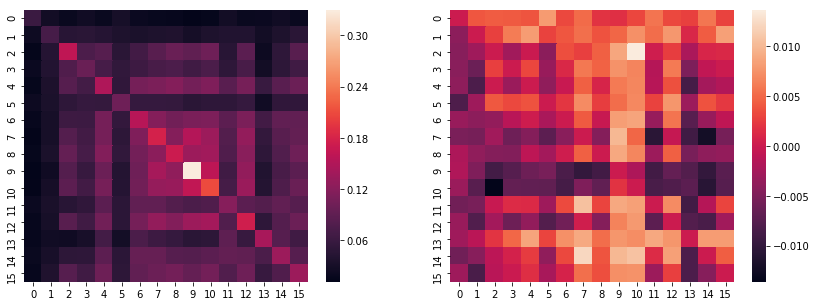

In [77]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
sns.heatmap(one_day_transfer_matrix)
plt.subplot(1,2,2)
sns.heatmap(one_day_transfer_matrix - one_day_transfer_matrix.T)

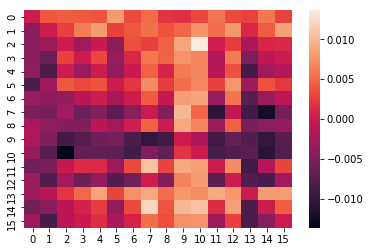

In [76]:
sns.heatmap(one_day_transfer_matrix - one_day_transfer_matrix.T)

In [83]:
id2_to_id3 = dict()
for id2 in range(122):
    id2_to_id3[id2] = sorted(frequent_users[frequent_users['id2'] == id2]['id3'].unique())

In [84]:
id2_to_id3

{0: [745, 924],
 1: [195, 207, 219, 530, 595, 796, 876],
 2: [96, 115, 138, 340, 347, 412, 496, 588, 753, 775, 816, 887, 902, 920],
 3: [16, 244, 281, 313, 430, 589, 613, 710, 762, 916],
 4: [48, 52, 125, 173, 232, 363, 545, 627, 679, 875],
 5: [303, 490, 754],
 6: [60, 146, 460, 659, 807],
 7: [34, 66, 130, 132, 180],
 8: [14, 67, 237, 253, 369, 542, 551, 645, 674, 865, 903],
 9: [20, 143, 233, 405, 445, 491, 631, 663, 863, 900, 917, 925],
 10: [50, 163, 521],
 11: [68, 150, 251, 409, 476, 494, 585, 665, 859, 914, 921],
 12: [10, 79, 204, 329, 398, 610, 633, 675, 725, 760, 833],
 13: [18, 101, 123, 229, 277, 486, 582, 670, 720, 824, 832],
 14: [51, 134, 581, 685, 711, 800, 843],
 15: [82, 97, 156, 165, 218, 260, 384, 439, 756, 786, 826],
 16: [28, 187, 621, 686, 703, 910],
 17: [5, 394, 452, 723, 780],
 18: [47,
  54,
  62,
  106,
  148,
  166,
  199,
  208,
  309,
  403,
  440,
  451,
  523,
  524,
  558,
  721,
  743,
  789,
  794,
  818,
  874],
 19: [171, 483, 528, 861],
 20: [4, 

In [96]:
%%time
one_day_transfer_matrix = np.zeros((931, 931))
d1 = 2
d2 = 3
for id2 in range(10):
    id3_range = id2_to_id3[id2]
    for pn1 in id3_range:
        u1 = frequent_users[(frequent_users['id3'] == pn1) & (frequent_users['date'] == d1)]['user_id'].unique()
        s1 = u1.shape[0]
        for pn2 in id3_range:
            u2 = frequent_users[(frequent_users['id3'] == pn2) & (frequent_users['date'] == d2)]['user_id'].unique()

            s2 = u2.shape[0]
            us = np.intersect1d(u1, u2, assume_unique=True).shape[0]

            if s1 + s2 == 0:
                one_day_transfer_matrix[pn1, pn2] = 0.0
            else:
                one_day_transfer_matrix[pn1, pn2] = us / (s1 + s2 - us)

CPU times: user 1min 23s, sys: 37.3 s, total: 2min 1s
Wall time: 2min 6s


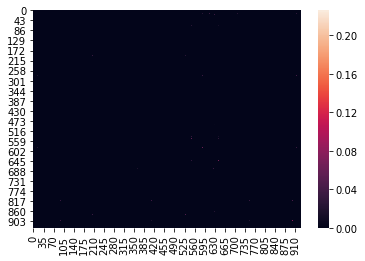

In [97]:
sns.heatmap(one_day_transfer_matrix)

In [100]:
one_day_transfer_matrix[one_day_transfer_matrix > 0]

array([ 0.08080551,  0.00929872,  0.0374868 ,  0.0171749 ,  0.03784404,
        0.01112485,  0.02440655,  0.04435058,  0.0411215 ,  0.01874311,
        0.03845141,  0.05897273,  0.03448276,  0.01712062,  0.01015697,
        0.03212521,  0.02374806,  0.03499157,  0.02232606,  0.00098619,
        0.02574417,  0.06758686,  0.03967762,  0.01178451,  0.03181189,
        0.01706749,  0.03374233,  0.01417848,  0.04218249,  0.00084531,
        0.03923492,  0.03333333,  0.00127959,  0.00140845,  0.00047371,
        0.00187266,  0.22622951,  0.00168492,  0.08005249,  0.06820682,
        0.03954424,  0.04131599,  0.02958293,  0.08936826,  0.00309598,
        0.01485536,  0.00219941,  0.05156627,  0.01622832,  0.02827225,
        0.02871007,  0.03109943,  0.03247184,  0.01250744,  0.0146379 ,
        0.02646503,  0.07211232,  0.04283186,  0.05122732,  0.02007136,
        0.02276952,  0.00109649,  0.06497623,  0.03425506,  0.04577088,
        0.02327624,  0.01463861,  0.04107143,  0.01489362,  0.02